## Image Clustering & Feature Extraction 




Images are difficult to analyze because of their high dimensionality. Here I analyzed the images of 80 of my classmates to find a few features that most clearly distinguish us from one another. After using two of these features (principal components) to plot the images, I ran k-means clustering to determine which images are most similar in appearance. 

This lab was done as part of CSE6040 Computing for Data Analytics with Professor Rich Vuduc at Georgia Tech. 

#### First, import necessary libraries...

In [1]:
import os
import sys
import re

import numpy as np
import pandas as pd

from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

from PIL import Image
import base64
from io import BytesIO

def to_base64 (png):
    return "data:image/png;base64," + base64.b64encode (png).decode("utf-8")

import bokeh
from bokeh.io import output_notebook
output_notebook ()
print ("Bokeh version:", bokeh.__version__)
#!conda upgrade bokeh   (uncomment to install bokeh)

Loading BokehJS ...

Bokeh version: 0.12.2


This code will create a color pallette for the points we'll be clustering:

In [2]:
from bokeh.palettes import brewer

def make_color_map (values):
    """Given a collection of discrete values, generate a color map."""
    unique_values = np.unique (values) # values must be discrete
    num_unique_values = len (unique_values)
    min_palette_size = min (brewer['Set1'].keys ())
    max_palette_size = max (brewer['Set1'].keys ())
    assert num_unique_values <= max_palette_size
    palette = brewer['Set1'][max (min_palette_size, num_unique_values)]
    color_map = dict (zip (unique_values, palette))
    return color_map

Builds the scatterplot we'll use in Bokeh: 

In [3]:
# http://bokeh.pydata.org/en/latest/docs/user_guide/tools.html#userguide-tools-inspectors
from bokeh.io import show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import PanTool, BoxZoomTool, ResizeTool, HoverTool, CrosshairTool, ResetTool

def make_scatter2d_images (x, y, names=None, image_files=None, clustering=None):
    source_data = dict (x=x, y=y)
    if names is not None:
        source_data["desc"] = names
        tooltips_desc = """<span style="font-size: 17px; font-weight: bold;">@desc</span>"""
    else:
        tooltips_desc = ""
        
    if image_files is not None:
        source_data["imgs"] = image_files
        tooltips_images = """
            <div>
                <img
                    src="@imgs" height="42" alt="@imgs" width="42"
                    style="float: left; margin: 0px 15px 15px 0px;"
                    border="2"
                ></img>
            </div>
        """
    else:
        tooltips_images = ""
        
    source = ColumnDataSource (data=source_data)
    hover = HoverTool (tooltips="""
        <div>
            {}
            <div>
                {}
                <span style="font-size: 15px; color: #966;">[$index]</span>
            </div>
            <div>
                <span style="font-size: 15px;">Location</span>
                <span style="font-size: 10px; color: #696;">($x, $y)</span>
            </div>
        </div>
        """.format (tooltips_images, tooltips_desc))

    TOOLS = [PanTool (), BoxZoomTool (), ResizeTool (), hover, CrosshairTool (), ResetTool ()]
    p = figure (width=600, height=300, tools=TOOLS)
    
    if clustering is not None:
        color_map = make_color_map (clustering)
        cluster_colors = [color_map[c] for c in clustering]
        p.circle (x='x', y='y',
                  fill_color=cluster_colors,
                  line_color=cluster_colors,
                  size=5, source=source)
    else:
        p.circle (x='x', y='y', size=5, source=source)
    return p

In [4]:
from scipy.cluster.vq import kmeans, vq

## The dataset

The dataset contains the thumbnail pictures of me and my classmates from our student IDs. Here's my picture. 

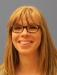

In [5]:
lara = Image.open ('peeps/lhulbert3--lara.tiff', 'r')
lara

Convert this image into a Numpy array of grayscale pixel intensities. 

In [6]:
def im2gnp (image):
    """Converts an image in pixels into an image stored as a grayscale 2-D Numpy array."""
    return np.array (image.convert ('L'))

pix_array= im2gnp(lara)
print("dimensions of the image:",pix_array.shape)
print("grayscale intensities array:")
pix_array

dimensions of the image: (75, 57)
grayscale intensities array:


array([[137, 137, 137, ..., 129, 129, 131],
       [136, 137, 137, ..., 129, 129, 130],
       [136, 137, 136, ..., 129, 129, 129],
       ..., 
       [177, 175, 167, ..., 115, 107, 116],
       [176, 173, 164, ..., 114, 105, 128],
       [176, 169, 158, ..., 115, 103, 132]], dtype=uint8)

Later we will need to convert a grayscale array back into an image. The `gnp2im` function does that. The `imshow_gray` function displays the grayscale image. 

My image in grayscale:


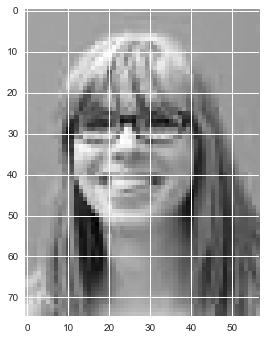

In [7]:
 def gnp2im (image_np):
    """Converts an image stored as a 2-D grayscale Numpy array back into an image in pixels."""
    return Image.fromarray (image_np.astype (np.uint8), mode='L')

def imshow_gray (im, ax=None):
    if ax is None:
        f = plt.figure ()
        ax = plt.axes ()
    ax.imshow (im,
               interpolation='nearest',
               cmap=plt.get_cmap ('gray'))                   
    
lara_np_gray = imshow_gray(lara.convert ('L'))
print("My image in grayscale:")
lara_np_gray

Now convert the thumbnail images of all of classmates to gray and make a list of grayscale Numpy arrays.

In [8]:
original_images = []
image_names = []
for base, dirs, files in os.walk ('peeps'):
    for filename in files:
        name_tiff = re.match (r'^(.*)\.tiff$', filename)
        if name_tiff:
            filepath = os.path.join (base, filename)
            im = im2gnp (Image.open (filepath, 'r'))
            key = name_tiff.groups (0)[0]
            
            original_images.append (im)
            image_names.append (key)
            
print ("There are ", len (original_images), "students.")

There are  88 students.


The names of my classmates are stored in the "image_names" list. This code uses regular expressions to throw out the student id peice of the image's file name and only keep the first name (which comes after two dashes). 

In [9]:
names = []
for key in image_names:
    key_fields = re.match (r'^(.*)--(.*)$', key)
    assert key_fields is not None
    names.append (key_fields.groups ()[1])
print("Some of my classmates' names:" ,names[0:5])

Some of my classmates' names: ['austin', 'abhishek', 'arjun', 'anurag', 'charles']


This code converts the pictures into a format that can be embedded in our interactive visualizations later. 

In [10]:
thumbnails = []
for gnp in original_images:
    im = gnp2im (gnp)
    memout = BytesIO ()
    im.save (memout, format='png')
    thumbnails.append (to_base64 (memout.getvalue ()))

## Preprocessing the images

Some data cleaning is needed before starting PCA because not all images have the same dimensions. Looking at the image dimensions, the smallest dimension was 56 pixels so all images will be cropped to a 56 x 56 square. Then we'll top-align the images and re-center, so as to keep the faces roughly in the space place in each picture. 

How to crop & re-center the image... 
   - If there are extra rows of pixels, crop off the excess rows from the bottom of the image (because we're assuming the face is an equal distance from the top of the image in most cases). 
   - If there are extra columns of pixels, crop off an equal number of columns from the left and the right sides of the image (to keep the face centered). 


Recentering: Before = 75 x 57 pixels; after = 56 x 56 pixels.

       Before recentering:                        After recentering:


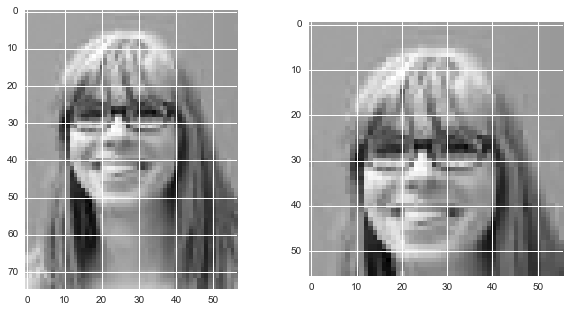

In [11]:
min_dim = 56 

def recenter (image, min_dim):
    
    r, c = image.shape    #dimensions of the uncropped image 

    top = 0                # because we want to align with the top 
    bottom = top + min_dim 
    left= int((c - min_dim)/2)   #approximately center the image 
    right= int((c + min_dim)/2)

    return image[top:bottom, left:right]    #crop the image 

lara = original_images[61]    

print ("Recentering: Before = {} x {} pixels; after = {} x {} pixels.".format (lara.shape[0],
                                                                               lara.shape[1],
                                                                               min_dim,
                                                                               min_dim))
lara_recentered = recenter (lara, min_dim)


fig, axs = plt.subplots (1, 2, figsize=(10, 5))
imshow_gray (lara, ax=axs[0])
print("\n       Before recentering:                        After recentering:")
imshow_gray (lara_recentered, ax=axs[1])

Now crop and re-center all the images: 

In [12]:
images_recentered = np.zeros ((len (original_images), min_dim, min_dim))
for (k, image) in enumerate (original_images):
    images_recentered[k, :, :] = recenter (image, min_dim)
    
#for the array, each k corresponds to one of us and the next dimensions are the pixel sizes. 


### Computing an "average" image

In order to perform principal component analysis, we need to have an "average" image. We'll compare all other images to this one to see how much the images vary from the average. 

Each image is stored as matrix of pixel color intensity. We can find look at all the images in the dataset and find the average color intensity of each pixel.

These mean color intensities will be stored in the array  `mean_image`.


 Here's the 'average' analytics student:


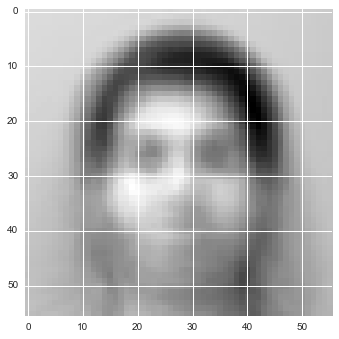

In [13]:
mean_image=np.mean(images_recentered,axis=0)
    
imshow_gray (mean_image)
gnp2im (mean_image)

print("\n Here's the 'average' analytics student:")

### Subrating the mean from each image
In order to tell how different we are from each other, we need first to figure out how different each student is from the mean image above. We can do this by subtracting the mean image from each of my classmates' images. 
`images_recentered` stores all of the cropped images of my classmates. 
The new array, `images`, stores the cropped image minus the mean image. 

In [14]:
images = images_recentered - mean_image 

Our original pictures and then the difference between our picture and the average analytics student.

        Me:               subtracted:           Daniel:        subtracted:


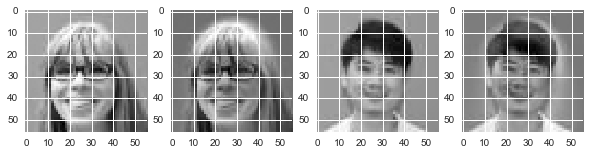

In [15]:
f, axs = plt.subplots (1, 4, figsize=(10, 40))
imshow_gray (images[61, :, :] + mean_image, ax=axs[0])
imshow_gray (images[61, :, :], ax=axs[1])
print("Our original pictures and then the difference between our picture and the average analytics student.")
print ("\n        Me:               subtracted:           Daniel:        subtracted:")

imshow_gray (images[48, :, :] + mean_image, ax=axs[2])
imshow_gray (images[48, :, :], ax=axs[3]) 



## From image set to a data matrix and back again

For PCA, you need a data matrix. Here is some code to convert our 3-D array of images into a 2-D data matrix, where we "flatten" each image into a 1-D vector by a simple `reshape` operation.

In [16]:
# Create m x d data matrix
m = len (images)  
d = min_dim * min_dim   #squared minimimum dimension for number of pixels 
X = np.reshape (images, (m, d))   #reshape rearranges the second 2 dimensions. X is now the data matrix. The rows correspond to u. Below, we pick the middle person and call reshape again to convert it back to a square. 

## Applying PCA

Here, we compute the SVD of `X`. Store the result in three arrays, `U`, `Sigma`, and `VT`, where `U` holds $U$, `Sigma` holds just the diagonal entries of $\Sigma$, and `VT` holds $V^T$.

In [17]:
U, Sigma, VT = np.linalg.svd(X,full_matrices=False)

Originally, my image was 56 pixel columns wide. 56 is too many features to analyze. So we use SVD to reshape the image matrix and find only the most important combinations of pixel features. The most important features will be the ones that are most useful at distinguishing our pictures clearly from one another. 

Here we'll plot the first few principal components as images. It's interesting to think about what features are being captured by these principal components. 

In the first picture, the characteristic that stands out the most is the hair. So PC1 learned that hair length is the feature that most differentiates my classmates from one another. 

Eyes aren't a prominent feature in the image below. That's because we all have eyes so the Principal Component Analysis ignored that pixel area since that's a poor differentiating feature among us. 

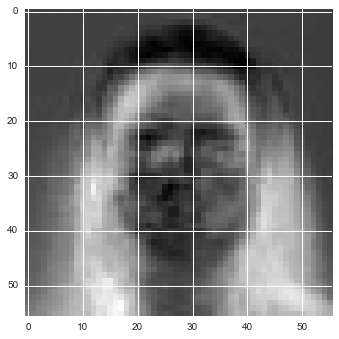

In [18]:
imshow_gray(np.abs(np.reshape(VT[0,:], (min_dim, min_dim))))


Principal Components 2 and 3 are plotted below. The features picked up here look to be forehead and chin color in PC2 and face color in PC3. So it appears that PCA learned that the second most significant difference between my classmates is skin color. 

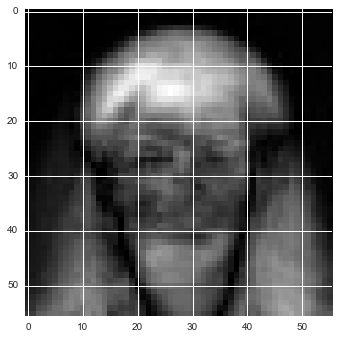

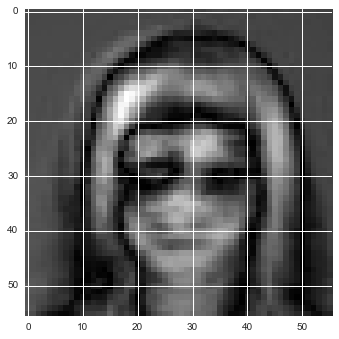

In [19]:
imshow_gray(np.abs(np.reshape(VT[1,:], (min_dim, min_dim))))

imshow_gray(np.abs(np.reshape(VT[2,:], (min_dim, min_dim))))

This code projects the original pixel matrix `Y`, onto the first 2 principal components. This will allow us to see how my classmates compare to one another. Classmates who look similarly will be theoretically be clustered together.

Then, we plot everyone's picture using the first 2 principal components as axes. PCA determined that the best set of axes to use would be hair length on the x-axis and skin tone on the y-axis. 


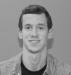
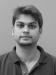
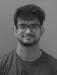
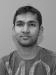
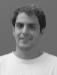
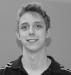
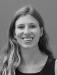
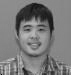
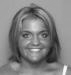
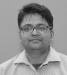
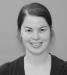
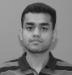
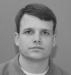
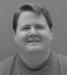
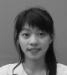
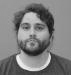
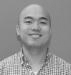
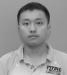
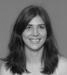
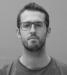
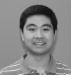
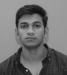
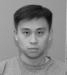
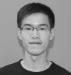
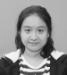
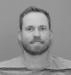
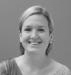
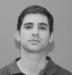
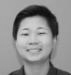
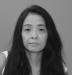
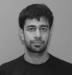
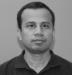
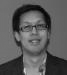
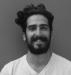
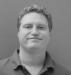
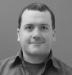
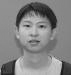
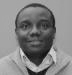
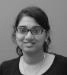
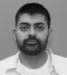
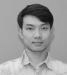
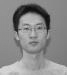
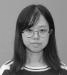
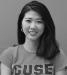
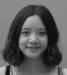
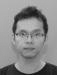
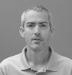
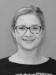
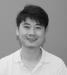
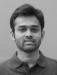
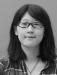
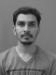
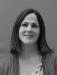
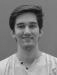
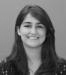
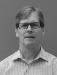
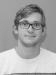
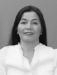
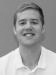
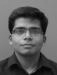
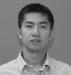
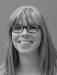
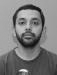
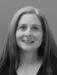
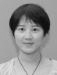
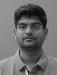
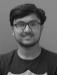
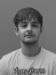
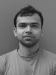
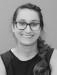
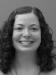
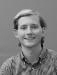
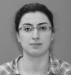
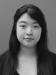
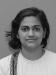
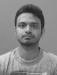
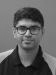
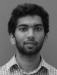
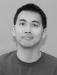
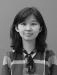
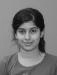
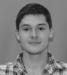
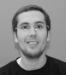
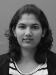
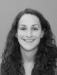
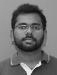
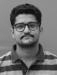
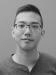

In [20]:
num_components = 2     # Number of principal components

Y = X.dot(VT[:num_components,:].T)   


p = make_scatter2d_images (Y[:, 0], Y[:, 1],
                           names=names,
                           image_files=thumbnails)
show (p)


Here, we run $k$-means on the projected data, to try to identify 4 clusters. 

[[  514.66036918  -651.70985787]
 [ 1458.69206373   649.00175135]
 [-1077.86967966   553.66652704]
 [ -751.93599086  -417.74366432]]



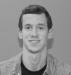
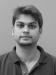
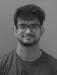
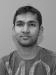
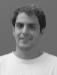
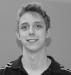
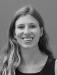
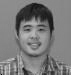
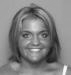
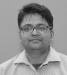
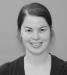
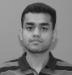
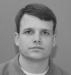
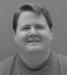
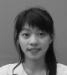
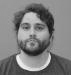
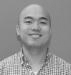
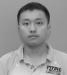
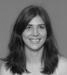
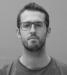
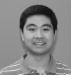
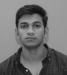
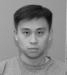
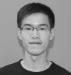
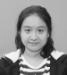
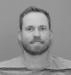
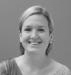
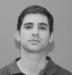
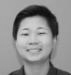
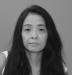
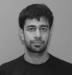
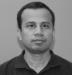
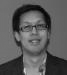
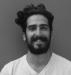
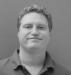
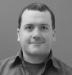
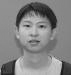
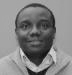
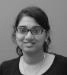
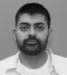
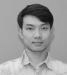
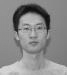
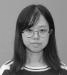
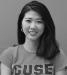
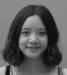
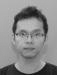
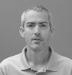
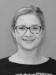
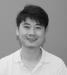
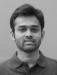
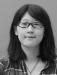
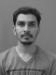
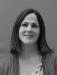
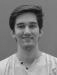
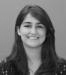
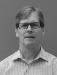
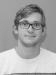
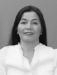
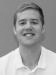
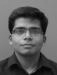
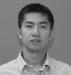
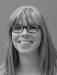
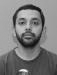
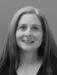
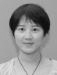
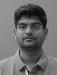
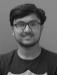
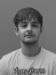
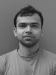
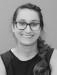
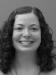
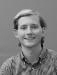
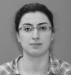
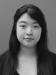
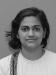
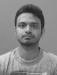
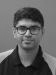
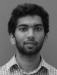
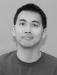
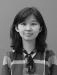
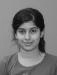
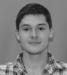
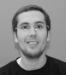
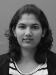
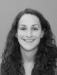
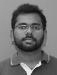
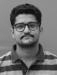
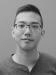

In [21]:
num_clusters = 4

centers, _ = kmeans(Y, num_clusters)     
clustering, _ = vq(Y,centers)

print (centers)

p = make_scatter2d_images (Y[:, 0], Y[:, 1],
                           names=names,
                           image_files=thumbnails,
                           clustering=clustering)
show (p)
 

The scree plot can help to determine the best value of k (the best number of clusters). Choose the value of k where the gains in accuracy start to level off. 

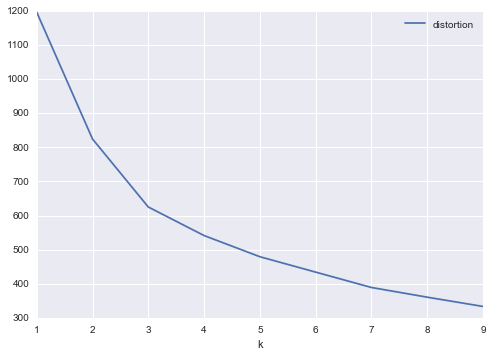

In [22]:
df_kcurve = pd.DataFrame (columns=['k', 'distortion']) 
for i in range(1,10):
    _, distortion = kmeans (Y, i)
    df_kcurve.loc[i] = [i, distortion]
df_kcurve.plot(x="k", y="distortion")
